# Training v3 - Update training data

In [2]:
# load in data

import pandas as pd
import pickle

with open('data/gdsc.pkl', 'rb') as f:
    gdsc1 = pickle.load(f)
    gdsc1_drugdata = pickle.load(f)
    gdsc2 = pickle.load(f)
    gdsc2_drugdata = pickle.load(f)

with open('data/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

with open('data/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

with open('data/preprocessed/processed_data2.pkl', 'rb') as f:
    xtrain = pickle.load(f)
    ylabel = pickle.load(f)
    ylabel_binary = pickle.load(f)
    index_to_sanger = pickle.load(f)

palbo = gdsc1.loc[gdsc1['DRUG_NAME'] == 'Palbociclib']
ln_ic50 = palbo['LN_IC50']
celllines = palbo['SANGER_MODEL_ID']

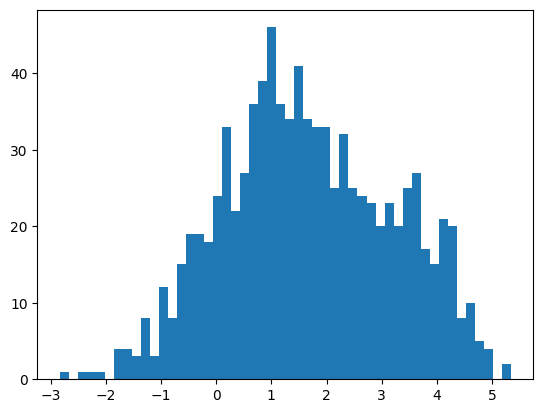

In [8]:
# visualise the distribution of IC50 values

import matplotlib.pyplot as plt

plt.hist(ln_ic50, bins=50)
plt.show()

In [10]:
from random import shuffle


test_size = 100

shuffle(xtrain)
shuffle(ylabel)

x_test = xtrain[:test_size]
partial_x_train = xtrain[test_size:]

y_test = ylabel_binary[:test_size]
partial_y_train = ylabel_binary[test_size:]


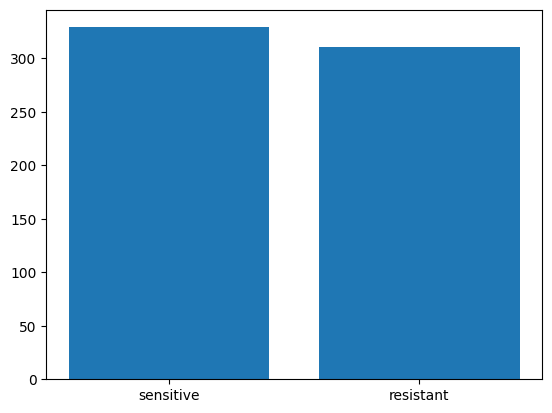

In [11]:
# visualise ylabels, ytests as bar plots 

import matplotlib.pyplot as plt

plt.bar(['sensitive', 'resistant'], [sum(ylabel_binary), len(ylabel_binary) - sum(ylabel_binary)])
plt.show()


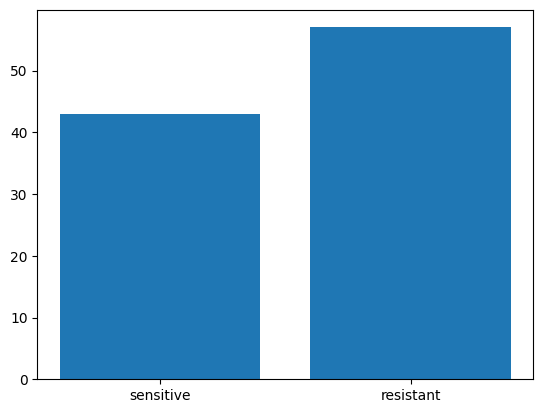

In [12]:
import matplotlib.pyplot as plt

plt.bar(['sensitive', 'resistant'], [sum(y_test), len(y_test) - sum(y_test)])
plt.show()

In [13]:
from keras import models
from keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

def create_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(len(gene_entrez)-1,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    return model 


## Cross-validation 

In [14]:
# fixed random seed for reproducibility
seed = 10
np.random.seed(seed)

model = KerasClassifier(model=create_model, epochs=20, batch_size=10, verbose=0)
# evaluate using 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(model, partial_x_train, partial_y_train, cv=kfold)
print(results.mean())
    

0.4796296296296296


## Test data evaluation

In [15]:
# import matplotlib.pyplot as plt
model = KerasClassifier(model=create_model, epochs=20, batch_size=10, verbose=0)
model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=10, verbose=0)
test_pred = model.predict(x_test)

print(test_pred)
print(y_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0.]
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1.]


Accuracy:  0.46
AUC:  0.4777641778865769


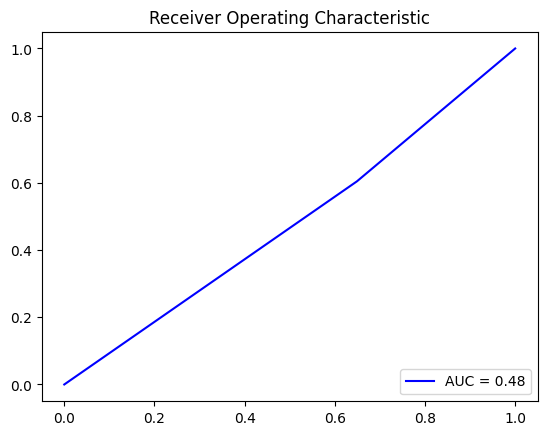

In [16]:
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt

acc = metrics.accuracy_score(y_test, test_pred)
print("Accuracy: ", acc)

fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)

roc_auc = metrics.auc(fpr, tpr)
print("AUC: ", roc_auc)



# Plot ROC 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.show()


# Implement feature selection

In [ ]:
# implement feature selection 

from sklearn.feature_selection import SelectKBest

In [17]:
from scipy import stats

x = stats.spearmanr([1, 2, 3, 4, 5], [5, 6, 7, 8, 7])
print(x)

SpearmanrResult(correlation=0.8207826816681233, pvalue=0.08858700531354381)


In [ ]:
from scipy.stats import f, spearmanr, pearsonr


# spearman r feature selection

def spearmanr_feature_selection(x, y, k):

    # calculate spearman correlation
    spearmanr_list = []
    for i in range(len(x[0])):
        spearmanr_list.append(spearmanr(x[:, i], y)[0])
    
    # sort spearman correlation
    spearmanr_list = np.array(spearmanr_list)
    spearmanr_list = np.argsort(spearmanr_list)
    spearmanr_list = spearmanr_list[::-1]

    # select top k features
    x_new = []
    for i in range(len(x)):
        x_new.append([])
        for j in range(k):
            x_new[i].append(x[i][spearmanr_list[j]])

    return x_new
    


In [19]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=2, n_redundant=8, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.815 (0.038)
